# TLC Trip Record Data

Yellow and green taxi trip records include fields capturing pickup and drop-off dates/times, pickup and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). The trip data was not created by the TLC, and TLC makes no representations as to the accuracy of these data.

For-Hire Vehicle (“FHV”) trip records include fields capturing the dispatching base license number and the pickup date, time, and taxi zone location ID (shape file below).These records are generated from the FHV Trip Record submissions made by bases, so we cannot guarantee or confirm their accuracy or completeness. The TLC performs routine reviews of the records and takes enforcement actions when necessary to ensure, to the extent possible, complete and accurate information. Since 2019 high volume trip records (HVFHV) are reported in a separate (and more detailed) dataset.

For 2025 data onwards, a cbd_congestion_fee column has been added to the Yellow, Green, and High Volume FHV datasets to reflect new congestion pricing charges.

## Librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.dates as mdates
from collections import defaultdict, deque
from datetime import timedelta
from scipy import stats
from shapely.geometry import Point
import contextily as ctx  

## Lectura de los dataset

In [ ]:
## datos NYC Taxi and Limousine Commission TLC
yellow_original= pd.read_parquet(r'C:\Users\LeidyDayannaPerezGir\Downloads\yellow_tripdata_2025-01.parquet')
green_original = pd.read_parquet(r'C:\Users\LeidyDayannaPerezGir\Downloads\green_tripdata_2025-01.parquet')
hvfhv_original = pd.read_parquet(r'C:\Users\LeidyDayannaPerezGir\Downloads\fhvhv_tripdata_2025-01.parquet')

In [ ]:
## shape
gdf = gpd.read_file(r"C:\Users\LeidyDayannaPerezGir\Downloads\taxi_zones\taxi_zones.shp")

In [95]:
## datos clima 
wall_street = pd.read_csv(r'C:\Users\LeidyDayannaPerezGir\Downloads\export (7).csv')
yorksville = pd.read_csv(r'C:\Users\LeidyDayannaPerezGir\Downloads\export (8).csv')
newark = pd.read_csv(r'C:\Users\LeidyDayannaPerezGir\Downloads\export (9).csv')
jf_kennedy = pd.read_csv(r'C:\Users\LeidyDayannaPerezGir\Downloads\export (10).csv')
linden = pd.read_csv(r'C:\Users\LeidyDayannaPerezGir\Downloads\export (11).csv')
teterboro = pd.read_csv(r'C:\Users\LeidyDayannaPerezGir\Downloads\export (12).csv')

In [5]:
yellow = yellow_original.copy()
green = green_original.copy()
hvfhv = hvfhv_original.copy()

## Unificación de columnas

In [6]:
vendor_dict = {
    "1": "Creative Mobile Technologies, LLC",
    "2": "Curb Mobility, LLC",
    "6": "Myle Technologies Inc",
    "7": "Helix",
    "HV0002": "Juno",
    "HV0003": "Uber",
    "HV0004": "Via",
    "HV0005": "Lyft"
}

yellow = yellow.rename(columns={
    'tpep_pickup_datetime': 'pickup_datetime',
    'tpep_dropoff_datetime': 'dropoff_datetime',
    'trip_distance': 'trip_miles',
    'tolls_amount': 'tolls',
    'tip_amount': 'tips',
    'total_amount': 'driver_pay', 
    'Airport_fee': 'airport_fee'
})

green = green.rename(columns={
    'lpep_pickup_datetime': 'pickup_datetime',
    'lpep_dropoff_datetime': 'dropoff_datetime',
    'trip_distance': 'trip_miles',
    'tolls_amount': 'tolls',
    'tip_amount': 'tips',
    'total_amount': 'driver_pay', 
    'Airport_fee': 'airport_fee'
})

hvfhv = hvfhv.rename(columns= {'hvfhs_license_num': 'VendorID'})      

hvfhv['VendorID'] = hvfhv['VendorID'].map(vendor_dict)
yellow['VendorID'] = yellow['VendorID'].astype(str).map(vendor_dict)
green['VendorID'] = green['VendorID'].astype(str).map(vendor_dict)

hvfhv['type_service'] = 'for_hire'
yellow['type_service'] = 'yellow'
green['type_service'] = 'green'

## Concatenación de dfs

In [7]:
cols_comunes = ['type_service','VendorID',
    'pickup_datetime', 'dropoff_datetime', 'trip_miles',
    'PULocationID', 'DOLocationID',
    'fare_amount', 'base_passenger_fare',
    'tolls', 'tips', 'driver_pay',
    'congestion_surcharge', 'cbd_congestion_fee', 'airport_fee'
]

yellow = yellow[[c for c in cols_comunes if c in yellow.columns]]
green  = green[[c for c in cols_comunes if c in green.columns]]
hvfhv  = hvfhv[[c for c in cols_comunes if c in hvfhv.columns]]

df_final = pd.concat([yellow, green, hvfhv], ignore_index=True)

In [8]:
df_final.isna().sum()

type_service                   0
VendorID                       0
pickup_datetime                0
dropoff_datetime               0
trip_miles                     0
PULocationID                   0
DOLocationID                   0
fare_amount             20405666
tolls                          0
tips                           0
driver_pay                     0
congestion_surcharge      541985
cbd_congestion_fee          1836
airport_fee               588475
base_passenger_fare      3523552
dtype: int64

In [9]:
print(df_final.info())
print(df_final.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23929218 entries, 0 to 23929217
Data columns (total 15 columns):
 #   Column                Dtype         
---  ------                -----         
 0   type_service          object        
 1   VendorID              object        
 2   pickup_datetime       datetime64[ns]
 3   dropoff_datetime      datetime64[ns]
 4   trip_miles            float64       
 5   PULocationID          int32         
 6   DOLocationID          int32         
 7   fare_amount           float64       
 8   tolls                 float64       
 9   tips                  float64       
 10  driver_pay            float64       
 11  congestion_surcharge  float64       
 12  cbd_congestion_fee    float64       
 13  airport_fee           float64       
 14  base_passenger_fare   float64       
dtypes: datetime64[ns](2), float64(9), int32(2), object(2)
memory usage: 2.5+ GB
None
  type_service                           VendorID     pickup_datetime  \
0       yell

## EDA

### Tipificación

In [10]:
df = df_final.copy()

for col in ['pickup_datetime', 'dropoff_datetime']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

### Características de tiempo y duración

In [11]:
df['duration_min'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60.0
df['pickup_hour']  = df['pickup_datetime'].dt.hour
df['pickup_wday']  = df['pickup_datetime'].dt.weekday   
df['is_weekend']   = (df['pickup_wday'] >= 5).astype('int8')

### Unificación de tarifa base

In [12]:
df['fare_equiv']  = np.where(df['fare_amount'].notna(), df['fare_amount'], df['base_passenger_fare'])
df['total_equiv'] = df['driver_pay']  

### Validaciones Básicas

In [13]:
df = df.query('duration_min > 0')

In [14]:
# Duración y distancia razonables

df = df.query('trip_miles > 0')

In [15]:
# Velocidad promedio
df['avg_mph'] = df['trip_miles'] / (df['duration_min'] / 60.0)
df = df[(df['avg_mph'] >= 0)]

In [16]:
## por fuera de fecha 
df =  df.query('pickup_datetime < "2025-02-01" and pickup_datetime  >= "2025-01-01" ')

In [17]:
# 4) Reglas lógicas básicas
# Fechas válidas
mask_time_ok = (df['pickup_datetime'].notna() & df['dropoff_datetime'].notna() &
                (df['dropoff_datetime'] >= df['pickup_datetime']))
df = df[mask_time_ok]

#TODO:  Decidir qué hacer con fare_equiv y total_equiv ya que son las variables más importantes a la hora de modelar regresión
# for col in ['fare_equiv', 'total_equiv']:
#     if col in df.columns:
#         # Si faltan, decide: imputar 0 (si "no aplica") o eliminar:
#         df[col] = df[col].fillna(0)
#         df = df[df[col] >= 0]

In [18]:
# 5) No negatividad e imputaciones benignas
for col in ['tolls', 'tips', 'congestion_surcharge', 'cbd_congestion_fee']:
    if col in df.columns:
        df[col] = df[col].fillna(0)
        df = df[df[col] >= 0]       

### Duplicados

In [19]:
df = df.drop_duplicates()

### Manejo de Outliers

In [20]:
# Decidir si esta regla es adecuada para el análisis, alternativa pordría ser con IQR
def winsorize_series(s: pd.Series, lower=0.005, upper=0.995):
    lo, hi = s.quantile([lower, upper])
    return s.clip(lower=lo, upper=hi)

winsor_cols = ['trip_miles', 'duration_min', 'avg_mph',
            'fare_equiv', 'tolls', 'tips', 'total_equiv']

for c in winsor_cols:
    if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
        df[c] = winsorize_series(df[c], 0.005, 0.995)

### Número de solicitudes cercanas

In [ ]:
df['fecha'] = pd.to_datetime(df['pickup_datetime'])
tuplas = zip(df.PULocationID, df.fecha)

grupos = defaultdict(list)

for loc_id, fecha in tuplas:
    grupos[loc_id].append(fecha)

    resultados = []

for loc_id, fechas in grupos.items():
    fechas.sort()
    ventana = deque()

    for fecha in fechas:
        while ventana and ventana[0] < fecha - timedelta(minutes=30):
            ventana.popleft()

        resultados.append((loc_id, fecha, len(ventana)))
        ventana.append(fecha)       

In [ ]:
# se ordena el df por PULocationID y fecha
df = df.sort_values(['PULocationID', 'fecha']).reset_index(drop=True)

# se ordena resultados
resultados.sort() 

# Inicializa los punteros y resultado
i = 0 
j = 0  
n = len(df)
m = len(resultados)

conteos = []

while i < n:
    df_loc = df.at[i, 'PULocationID']
    df_fecha = df.at[i, 'fecha']

    matched = False

    while j < m:
        res_loc, res_fecha, res_conteo = resultados[j]

        if (res_loc, res_fecha) < (df_loc, df_fecha):
            j += 1
        elif (res_loc, res_fecha) == (df_loc, df_fecha):
            conteos.append(res_conteo)
            matched = True
            break
        else:
            break

    if not matched:
        conteos.append(None)  
    i += 1


df['number_requests'] = conteos

### Casteo Final

In [ ]:
int_cols = ['PULocationID', 'DOLocationID', 'pickup_hour', 'pickup_wday', 'is_weekend']
for c in int_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').astype('Int64')

float_cols = ['trip_miles', 'duration_min', 'avg_mph',
            'fare_equiv', 'tolls', 'tips', 'total_equiv',
            'congestion_surcharge', 'cbd_congestion_fee', 'airport_fee']
for c in float_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').astype('float64')

cols_model = [
    'pickup_datetime', 'dropoff_datetime',
    'PULocationID', 'DOLocationID',
    'trip_miles', 'duration_min', 'avg_mph',
    'pickup_hour', 'pickup_wday', 'is_weekend',
    'fare_equiv', 'tolls', 'tips', 'total_equiv',
    'congestion_surcharge', 'cbd_congestion_fee', 'airport_fee'
]
cols_model = [c for c in cols_model if c in df.columns]

df_model = df[cols_model].reset_index(drop=True)        

In [ ]:
print(df_model.info())
df_model.head()

### Distribuciones

In [ ]:
sns.set_theme(style='whitegrid', palette='Set2')
plt.rcParams['figure.figsize'] = (10, 5)

num_cols = ['trip_miles', 'duration_min', 'avg_mph',
            'fare_equiv', 'tolls', 'tips', 'total_equiv']

for col in num_cols:
    if col in df_model.columns:
        plt.figure()
        sns.histplot(df_model[col], kde=True, bins=50)
        plt.title(f'Distribución de {col}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.show()

### Boxplots

In [ ]:
for col in num_cols:
    if col in df_model.columns:
        plt.figure()
        sns.boxplot(x=df_model[col])
        plt.title(f'Boxplot de {col}')
        plt.show()

### Correlación

In [ ]:
numeric_df = df_model.select_dtypes(include=[np.number])
corr = numeric_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de correlaciones")
plt.show()

In [ ]:
if 'total_equiv' in numeric_df.columns:
    corr_target = corr['total_equiv'].sort_values(ascending=False)
    print("📊 Correlaciones con total_equiv:")
    print(corr_target)

### Estacionalidad

In [ ]:
if {'pickup_hour', 'pickup_wday'}.issubset(df_model.columns):
    plt.figure()
    sns.boxplot(x='pickup_hour', y='total_equiv', data=df_model)
    plt.title('Total_equiv por hora de recogida')
    plt.show()

    plt.figure()
    sns.boxplot(x='pickup_wday', y='total_equiv', data=df_model)
    plt.title('Total_equiv por día de la semana (0=Lunes)')
    plt.show()

### Patrones Espaciales

In [ ]:
if {'PULocationID', 'DOLocationID'}.issubset(df_model.columns):
    top_pu = df_model['PULocationID'].value_counts().head(10)
    top_do = df_model['DOLocationID'].value_counts().head(10)

    plt.figure()
    sns.barplot(x=top_pu.index, y=top_pu.values)
    plt.title("Top 10 zonas de origen más frecuentes")
    plt.xlabel("PULocationID")
    plt.ylabel("Número de viajes")
    plt.show()

    plt.figure()
    sns.barplot(x=top_do.index, y=top_do.values)
    plt.title("Top 10 zonas de destino más frecuentes")
    plt.xlabel("DOLocationID")
    plt.ylabel("Número de viajes")
    plt.show()

### Graficamos el shape

In [42]:
df.describe().to_clipboard()

In [47]:
df[['type_service', 'VendorID']].value_counts().to_clipboard()

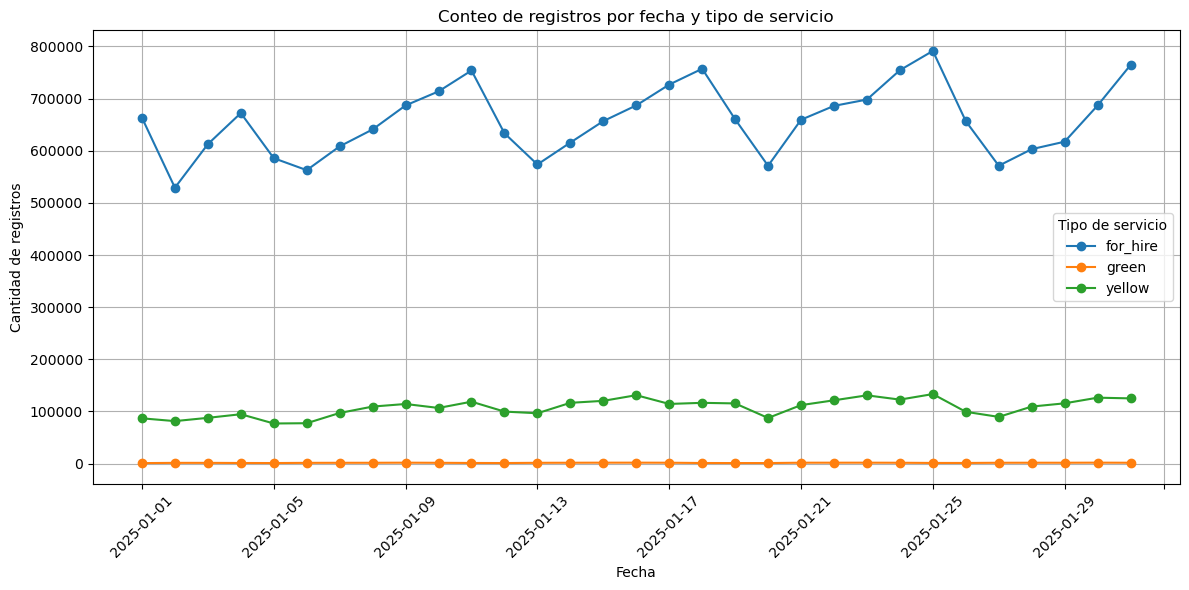

In [ ]:
# Agrupar por mes y tipo de servicio
df['fecha'] = df['pickup_datetime'].dt.strftime('%Y-%m-%d')
pdf = (
           df.groupby(["fecha", "type_service"])
          .size().reset_index())    


# Ordenar por fecha
pdf = pdf.sort_values("fecha")

# Graficar
plt.figure(figsize=(12,6))
for service, data in pdf.groupby("type_service"):
    plt.plot(data["fecha"], data[0], marker="o", label=service)

plt.title("Conteo de registros por fecha y tipo de servicio")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de registros")
plt.legend(title="Tipo de servicio")
plt.grid(True)


plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

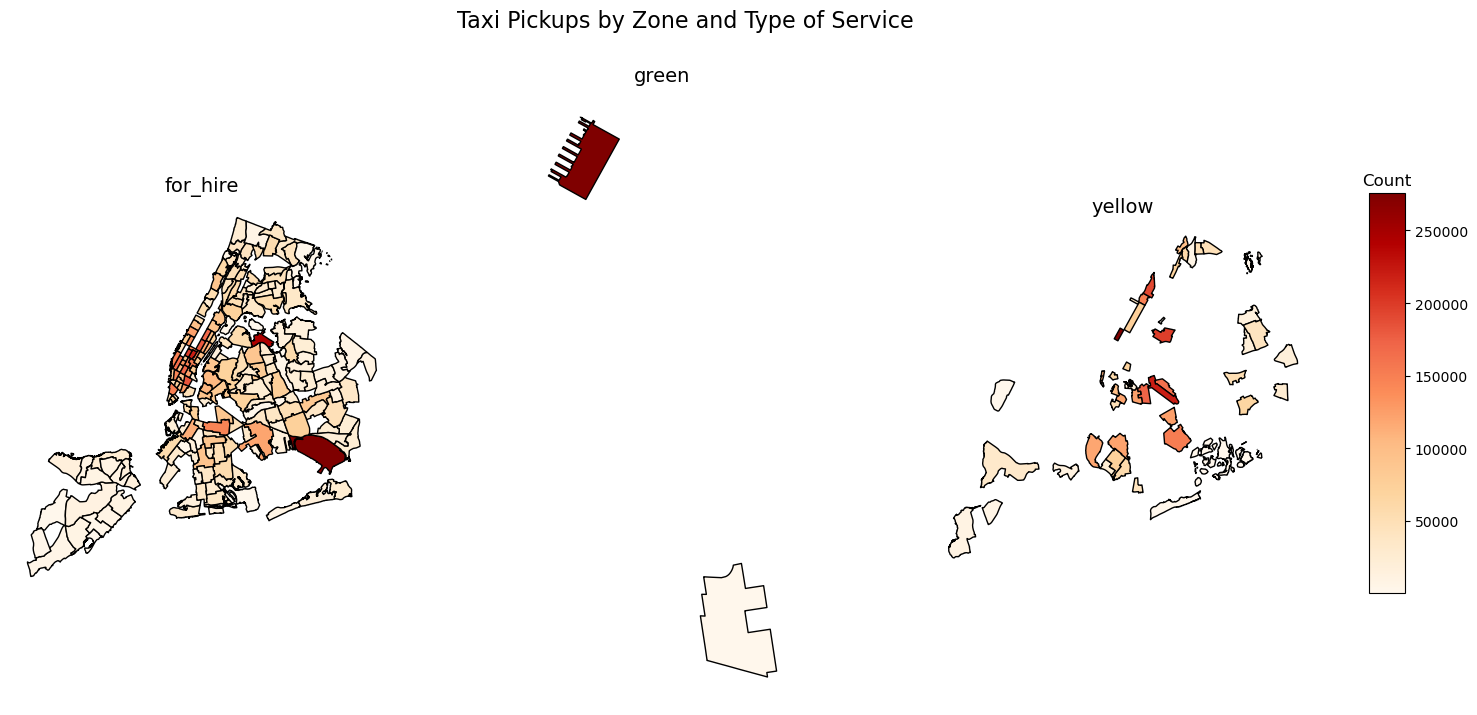

In [ ]:
#contar los pickups por zona y tipo de servicio 
pickup_counts = (
    df.groupby(["PULocationID", "type_service"])
      .size()
      .reset_index(name="count")
)

# Unir con el shapefile 

pickup_map = gdf.merge(
    pickup_counts,
    left_on="LocationID",
    right_on="PULocationID",
    how="left"
)

#Graficar todos los type_service en un solo lienzo 
type_services = sorted(df["type_service"].dropna().unique())
n = len(type_services)

fig, axes = plt.subplots(1, n, figsize=(6 * n, 8))
if n == 1:
    axes = [axes]  

for ax, service in zip(axes, type_services):
    data = pickup_map[pickup_map["type_service"] == service]
    im = data.plot(
        column="count",
        cmap="OrRd",
        legend=False, 
        ax=ax,
        edgecolor="black"
    )
    ax.set_title(service, fontsize=14)
    ax.axis("off")

# Crear una única barra de color
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])  
fig.colorbar(im.collections[0], cax=cbar_ax)
cbar_ax.set_title("Count", fontsize=12)

plt.suptitle("Taxi Pickups by Zone and Type of Service", fontsize=16)
plt.show()

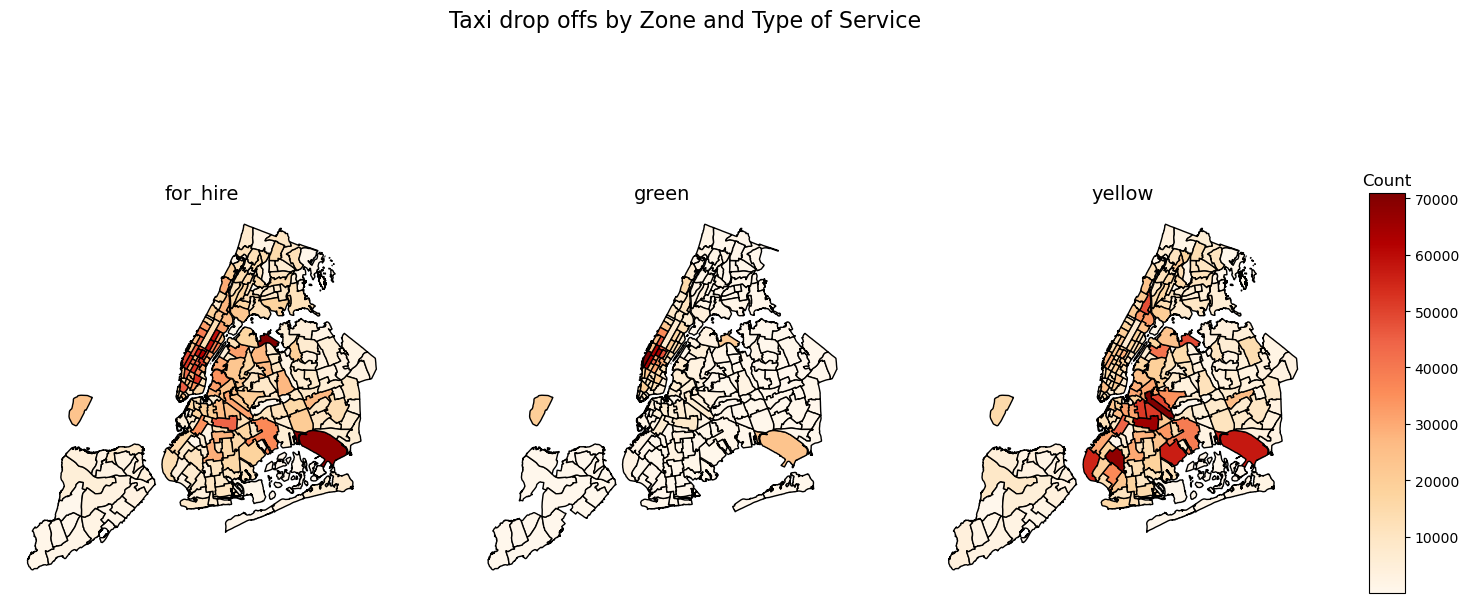

In [ ]:
# Contar los pickups por zona y tipo de servicio 
pickup_counts = (
    df.groupby(["DOLocationID", "type_service"])
      .size()
      .reset_index(name="count")
)

# Unir con el shapefile 

pickup_map = gdf.merge(
    pickup_counts,
    left_on="LocationID",
    right_on="DOLocationID",
    how="left"
)

# Graficar todos los type_service en un solo lienzo 
type_services = sorted(df["type_service"].dropna().unique())
n = len(type_services)

fig, axes = plt.subplots(1, n, figsize=(6 * n, 8))
if n == 1:
    axes = [axes]  
for ax, service in zip(axes, type_services):
    data = pickup_map[pickup_map["type_service"] == service]
    im = data.plot(
        column="count",
        cmap="OrRd",
        legend=False,  
        ax=ax,
        edgecolor="black"
    )
    ax.set_title(service, fontsize=14)
    ax.axis("off")

#  Crear una única barra de color 
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])  
fig.colorbar(im.collections[0], cax=cbar_ax)
cbar_ax.set_title("Count", fontsize=12)

plt.suptitle("Taxi drop offs by Zone and Type of Service", fontsize=16)
plt.show()

## Dataset clima 

In [101]:
cols = ['temp', 'prcp']

for col in cols: 

    medias_col = pd.DataFrame({
        "wall_street": [wall_street[col].mean()],
        "yorksville": [yorksville[col].mean()],
        "newark": [newark[col].mean()], 
        "jf_kennedy":[jf_kennedy[col].mean()],
        "teterboro":[teterboro[col].mean()],
        "linden": [linden[col].mean()] 
    })

    print(medias_col.T)

                    0
wall_street  0.835764
yorksville   0.058681
newark       0.593056
jf_kennedy   1.287500
teterboro   -0.228472
linden       0.008681
                    0
wall_street  0.012847
yorksville   0.015278
newark       0.007692
jf_kennedy   0.009386
teterboro    0.005283
linden       0.013542


In [103]:
cols = ['temp', 'prcp']

for col in cols: 

    f_stat, p_val = stats.f_oneway(
        wall_street[col].dropna(),
        yorksville[col].dropna(),
        newark[col].dropna(), 
        jf_kennedy[col].dropna(),
        teterboro[col].dropna(),
        linden[col].dropna() 
    )

    print(f"Estadístico F {col}: {f_stat:.4f}")
    print(f"p-valor {col}: {p_val:.6f}")

Estadístico F temp: 8.0614
p-valor temp: 0.000000
Estadístico F prcp: 0.7424
p-valor prcp: 0.591660


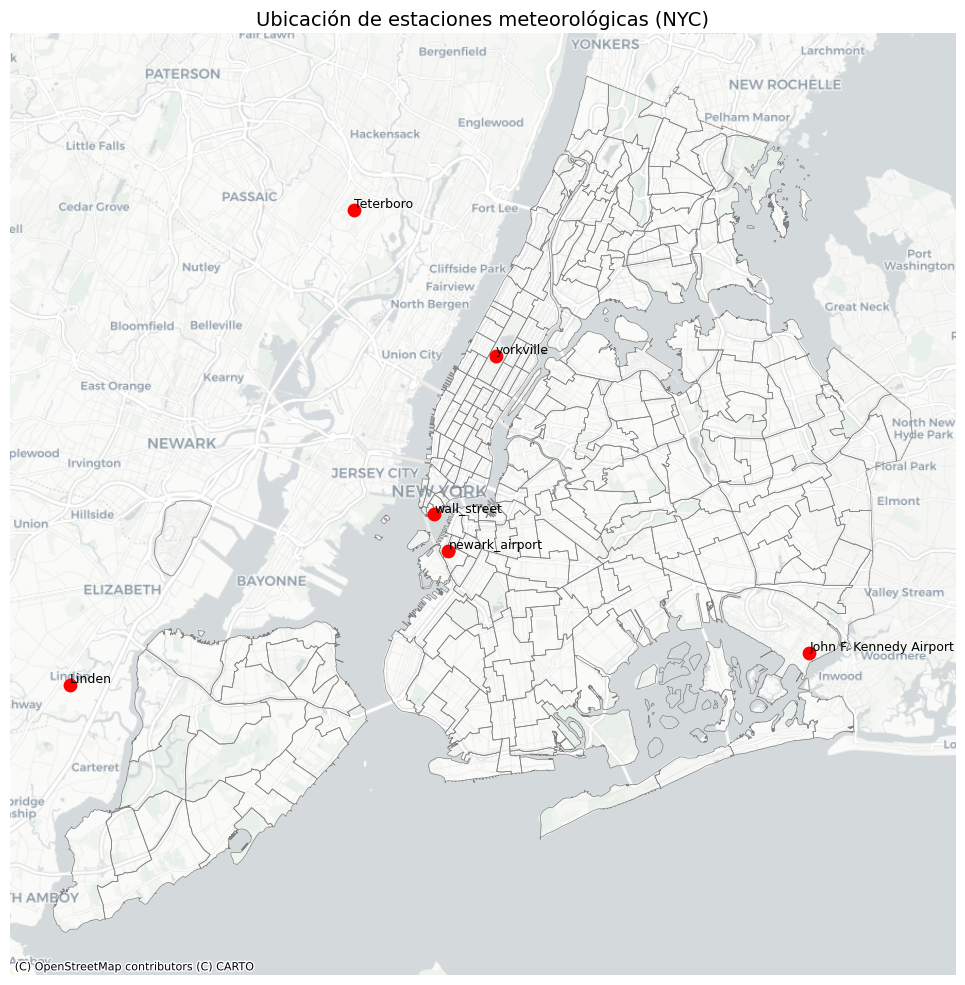

In [87]:
#  puntos de referencia
coords = [
    (40.7012, -74.009),   # Wall Street
    (40.6833, -74.0000),  # Newark Airport 
    (40.7789, -73.9692),  # Yorkville
    (40.6333, -73.7667),  # aiorport jhonf keneddy  
    (40.8501, -74.0608),  # teterboro
    (40.6174, -74.2446)   # linden
]

names = ["wall_street", "newark_airport", "yorkville", 'John F. Kennedy Airport',  'Teterboro', 'Linden']

points = gpd.GeoDataFrame(
    {"name": names},
    geometry=[Point(lon, lat) for lat, lon in coords],
    crs="EPSG:4326"
)

# Convertir ambos al CRS Web Mercator 
gdf = gdf.to_crs(epsg=3857)
points = points.to_crs(epsg=3857)

# Graficar
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color="none", edgecolor="gray", linewidth=0.5)
points.plot(ax=ax, color="red", markersize=80)

# Agregar etiquetas
for x, y, label in zip(points.geometry.x, points.geometry.y, points["name"]):
    ax.text(x, y, label, fontsize=9, ha="left", va="bottom", color="black")

# Agregar mapa base tipo Google / OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)  

# Ajustes finales
ax.set_axis_off()
plt.title("Ubicación de estaciones meteorológicas (NYC)", fontsize=14)
plt.tight_layout()
plt.show()